# Classifying Footwear with a QNN

## Authors : Kieran McDowall, NQCC. Max Arnott, Zaiku.

In [14]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split
from circuit_layers import conv_circuit, conv_layer, pool_circuit, pool_layer, encode_image_to_quantum
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit.library import EfficientSU2

algorithm_globals.random_seed = 12345

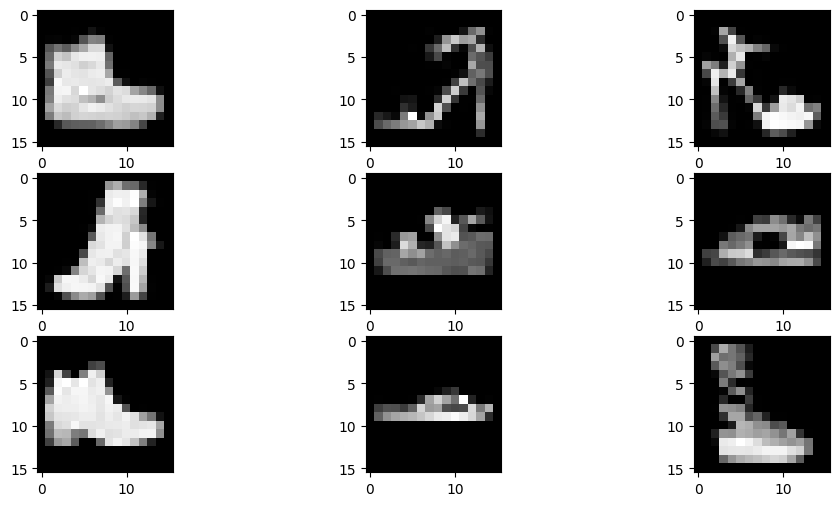

Training data length is: 200
Test / train split is: 0.3


In [15]:
from matplotlib import pyplot
from keras.datasets import fashion_mnist
import numpy as np

Map ='Stnd Amp.' #'Gnomonic' # # , 'Stereographic'
train_size = 200
test_size = 60
loss = 'cross_entropy' # 
model = 'eqv' # non-eqv
repeats = 20


# load dataset
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()
train_indices = []
test_indices = []
train_labels = []
test_labels = []

#selecting only boots and sandals from the dataset
for i in range(len(trainy)):
    if (trainy[i] == 5) or (trainy[i] == 9):
        train_indices.append(i)
    if trainy[i] == 5:
        train_labels.append(1)
    if trainy[i] == 9:
        train_labels.append(-1)
    
# print(len(train_labels))


for i in range(len(testy)):
    if (testy[i] == 5) or (testy[i] == 9): # 5 = sandal, 9 = boot
        test_indices.append(i)
    if testy[i] == 5:
        test_labels.append(1) # 1 = sandal
    if testy[i] == 9:
        test_labels.append(-1) # -1 = boot

    

#resizing
trainX_shoes_small = [trainX[i] for i in train_indices]
trainy_shoes = [trainy[i] for i in train_indices]
testX_shoes_small = [testX[i] for i in test_indices]
testy_shoes = [testy[i] for i in test_indices]

trainy_shoes = [1 if x == 5 else -1 for x in trainy_shoes]
testy_shoes = [1 if x == 5 else -1 for x in testy_shoes]

trainX_shoes = []
for i in range(len(trainX_shoes_small)):
  new_image = np.zeros((32, 32), dtype=trainX_shoes_small[i].dtype)
  new_image[2:-2, 2:-2] = trainX_shoes_small[i]
  trainX_shoes.append(new_image)

testX_shoes = []
for i in range(len(testX_shoes_small)):
  new_image = np.zeros((32, 32), dtype=testX_shoes_small[i].dtype)
  new_image[2:-2, 2:-2] = testX_shoes_small[i]
  testX_shoes.append(new_image)
  


# Define sample size
trainX_shoes = trainX_shoes[0:train_size]
train_labels = train_labels[0:train_size]
testX_shoes = testX_shoes[0:test_size]
test_labels = test_labels[0:test_size]


def pixelate_image(image):
    
    new_image = np.zeros((16, 16))
    
    for i in range(16):
        for j in range(16):
            
            new_image[i, j] = np.mean(image[i*2:(i+1)*2, j*2:(j+1)*2])
    
    return new_image


trainX_shoes16 = []
for i in range(len(trainX_shoes)):
    trainX_shoes16.append(pixelate_image(trainX_shoes[i]))
    

testX_shoes16 = []
for i in range(len(testX_shoes)):
    testX_shoes16.append(pixelate_image(testX_shoes[i])) 

  
import random
indices_to_flip_train = random.sample(range(len(trainX_shoes16)), len(trainX_shoes16) // 2)
indices_to_flip_test = random.sample(range(len(testX_shoes16)), len(testX_shoes16) // 2)

for index in indices_to_flip_train:
    # Flip the image horizontally
    trainX_shoes16[index] = trainX_shoes16[index][:, ::-1]

for index in indices_to_flip_test:
    # Flip the image horizontally
    testX_shoes16[index] = testX_shoes16[index][:, ::-1]

for i in range(9):
 # define subplot
 pyplot.subplot(330 + 1 + i)
 # plot raw pixel data
 pyplot.imshow(trainX_shoes16[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

print('Training data length is:', len(trainX_shoes16))
print('Test / train split is:', len(testX_shoes16)/len(trainX_shoes16))



#### 1) Need to flatten arrays
trainX_shoes_final = []
testX_shoes_final = []

for i in range(len(trainX_shoes16)):
    trainX_shoes_final.append(trainX_shoes16[i].flatten())

for i in range(len(testX_shoes16)):    
    testX_shoes_final.append(testX_shoes16[i].flatten())



from qiskit import QuantumCircuit, transpile, assemble

def normalize(image):
    norm = np.linalg.norm(image)
    return image / norm

def encode_image_to_quantum(image):
    # Flatten the image to a 1D array
    image = image.flatten()
    
    # Normalize the image pixel values to form a valid quantum state
    normalized_image = normalize(image)
    
    # Initialize a quantum circuit with 4 qubits
    num_qubits = 8
    qc = QuantumCircuit(num_qubits)
    
    # Prepare the quantum state from the normalized pixel values
    qc.initialize(normalized_image, range(num_qubits))
    
    return qc


In [16]:
##!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate, RXGate


## More expresive?! With rxx into ryys and rzzs 
def eqv_circ_eff(params):

    qc = QuantumCircuit(8)
    
    # Type A - within 0-3

    qc.rx(params[0], 0)
    qc.rx(params[1], 1)
    qc.rx(params[2], 2)
    qc.rx(params[3], 3)
    
    qc.ry(params[4], 4)
    qc.ry(params[5], 5)
    qc.ry(params[6], 6)
    qc.ry(params[7], 7)

    qc.rx(params[8], 0)
    qc.rx(params[9], 1)
    qc.rx(params[10], 2)
    qc.rx(params[11], 3)

    qc.rz(params[12], 4)
    qc.rz(params[13], 5)
    qc.rz(params[14], 6)
    qc.rz(params[15], 7)

    # Entangling
    qc.cx(6,7)
    qc.cx(5,6)
    qc.cx(4,5)
    qc.rxx(np.pi/2,3,4)
    qc.ryy(np.pi/2,2,3) # some of these can be ryy, rzz
    qc.rzz(np.pi/2,1,2)
    qc.rxx(np.pi/2,0,1)
    #####
    
    qc.rx(params[16], 0)
    qc.rx(params[17], 1)
    qc.rx(params[18], 2)
    qc.rx(params[19], 3)
    
    qc.ry(params[20], 4)
    qc.ry(params[21], 5)
    qc.ry(params[22], 6)
    qc.ry(params[23], 7)

    qc.rx(params[24], 0)
    qc.rx(params[25], 1)
    qc.rx(params[26], 2)
    qc.rx(params[27], 3)

    qc.rz(params[28], 4)
    qc.rz(params[29], 5)
    qc.rz(params[30], 6)
    qc.rz(params[31], 7)
    
    
    return qc

In [17]:
from qiskit.circuit import Parameter


qubits = 8


feature_map = RawFeatureVector(2**qubits)



# Initialize ansatz for 10 qubits
# ansatz = QuantumCircuit(8, name="Ansatz")
if model == 'non-eqv':
    ansatz = EfficientSU2(num_qubits=8, reps=1)
elif model == 'eqv':
    params = ParameterVector("θ", length=32)
    # Initialize ansatz for 10 qubits
    ansatz = eqv_circ_eff(params)

# No Pooling Layer needed as we reduce to 1 qubit directly

# Combining the feature map and ansatz
circuit = QuantumCircuit(qubits)
circuit.compose(feature_map, range(qubits), inplace=True)
circuit.compose(ansatz, range(qubits), inplace=True)

circvis = QuantumCircuit(qubits)
circvis.compose(ansatz, range(qubits), inplace=True)
# Adjust observable for 6 qubits
if model == 'non-eqv':
    observable = SparsePauliOp.from_list([("Z" * 8, 1)])
elif model == 'eqv':
    # Adjust observable for 6 qubits
    observable = SparsePauliOp.from_list([("X" * 4+ "Z" * 4, 1)])



# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit,
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

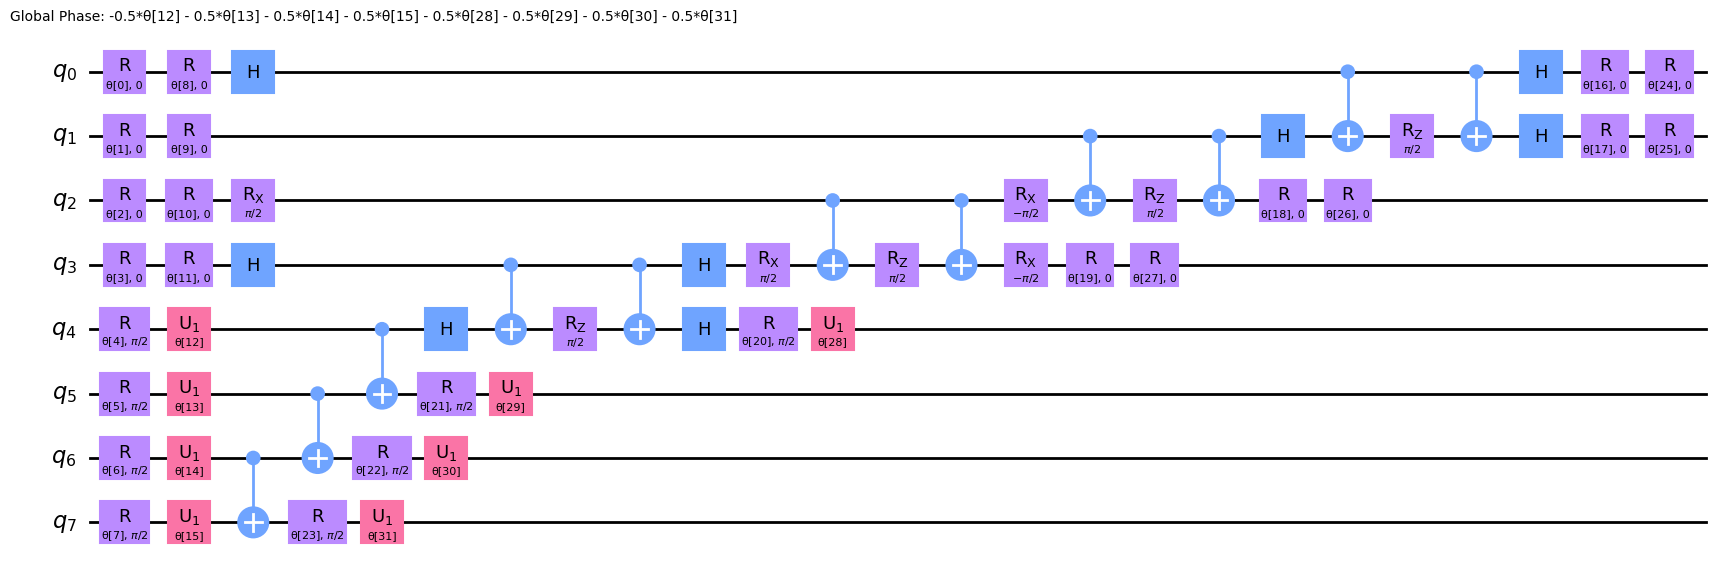

In [18]:
circvis.decompose().draw("mpl", style="clifford")

In [21]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [22]:
iters = 200

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=iters),  # Set max iterations here
    callback=callback_graph,
    loss = loss
    # initial_point=initial_point, # if you have one!!
)

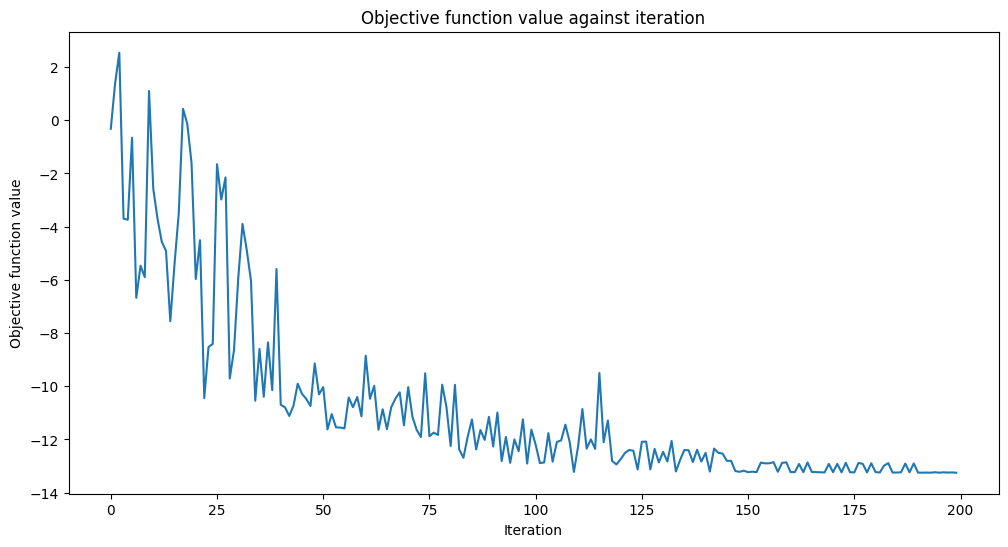

Accuracy from the train data : 93.33%
Accuracy from the test data : 93.33%


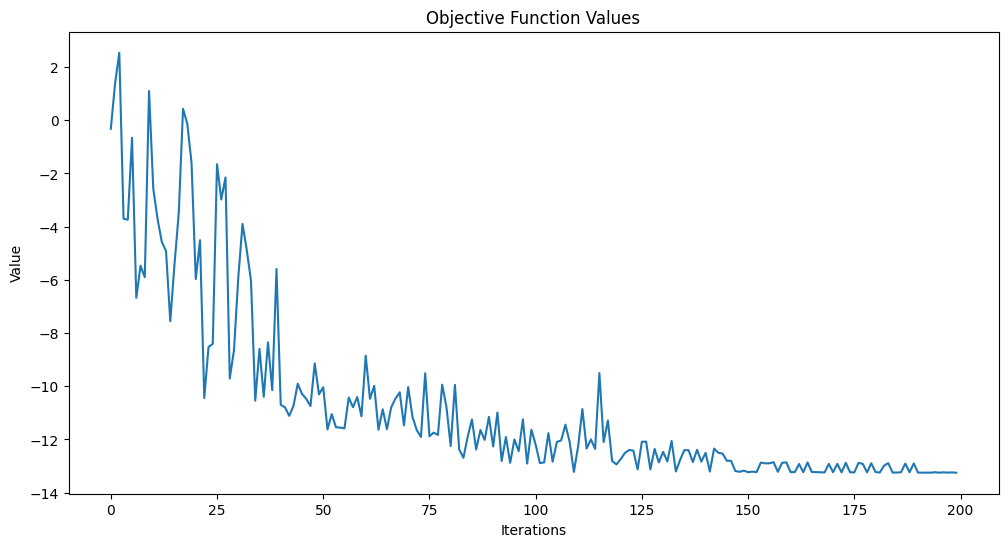

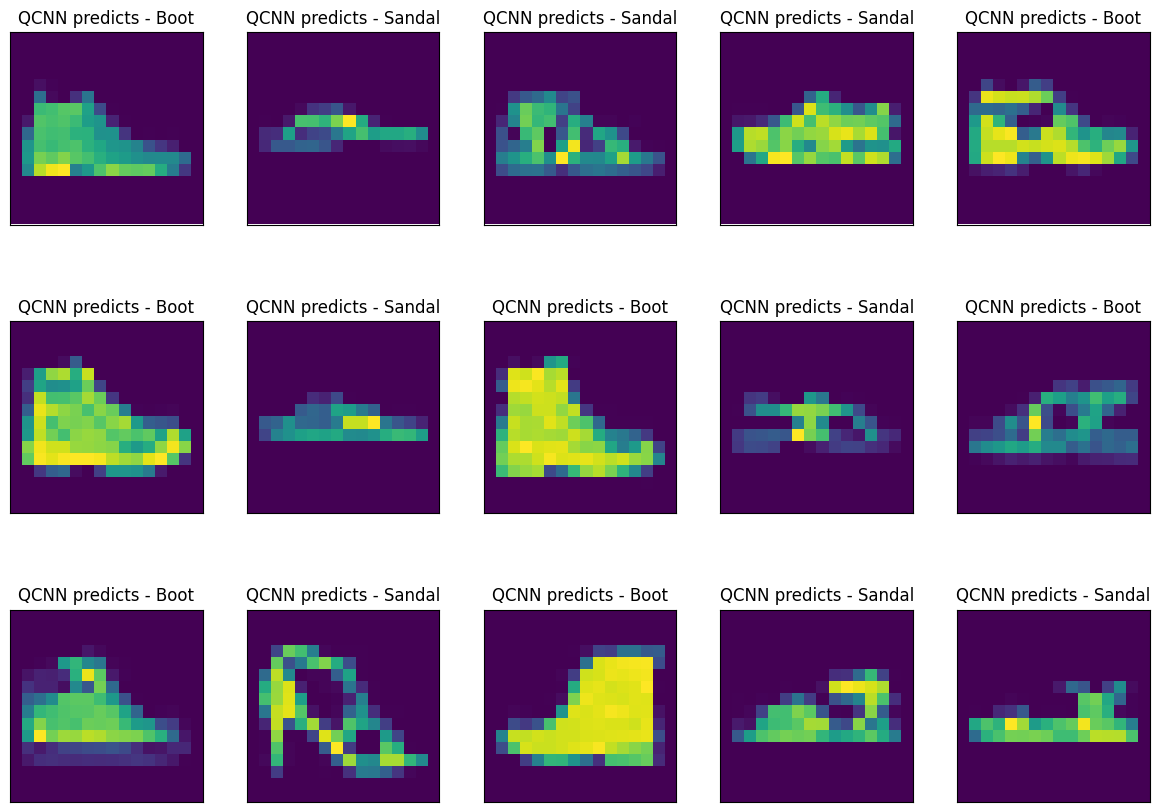

In [24]:
import timeit
import time
# Get the current date and time
# current_datetime = datetime.datetime.now()
timestr = time.strftime("%Y%m%d-%H%M%S")

x = np.asarray(trainX_shoes_final)
y = np.asarray(train_labels)



accum_objective_func_vals = []
train_accs = []
test_accs = []
train_times = []
test_times = []


for i in range(repeats):

    start = timeit.default_timer()
    objective_func_vals = []
    plt.rcParams["figure.figsize"] = (12, 6)
    classifier.fit(x, y)
    stop = timeit.default_timer()
    train_time = stop - start
    
    train_times.append(train_time)
    
    # Create a plot (example plot, replace with your actual plot logic)
    plt.plot(objective_func_vals)
    plt.title('Objective Function Values')
    plt.xlabel('Iterations')
    plt.ylabel('Value')
    plt.savefig(f'Results_shoes/Final/loss{loss}_{model}_rep{i}_{Map}_N{qubits}_its{iters}_{timestr}.pdf', format='pdf', bbox_inches='tight')

    accum_objective_func_vals.append(objective_func_vals)
    
    train_acc = np.round(100 * classifier.score(x, y), 2)
    # score classifier
    print(f"Accuracy from the train data : {train_acc}%") 
    train_accs.append(train_acc)
    

    start = timeit.default_timer()
    y_predict = classifier.predict(testX_shoes_final)
    # Stop timer
    stop = timeit.default_timer()
    test_time = stop - start
    test_times.append(test_time)
    
    x = np.asarray(testX_shoes_final)
    y = np.asarray(test_labels)
    
    test_acc = np.round(100 * classifier.score(x, y), 2)
    print(f"Accuracy from the test data : {test_acc}%")
    test_accs.append(test_acc)
    
    # Let's see some examples in our dataset
    fig, ax = plt.subplots(3, 5, figsize=(15, 10), subplot_kw={"xticks": [], "yticks": []})
    for i in range(15):  # Adjusted for 3 rows and 5 columns (3*5 = 15)
        ax[i // 5, i % 5].imshow(np.asarray(testX_shoes_final[i]).reshape(16, 16), aspect="equal")    #, cmap='gray'
        if y_predict[i] == -1:
            ax[i // 5, i % 5].set_title("QCNN predicts - Boot")
        elif y_predict[i] == +1:
            ax[i // 5, i % 5].set_title("QCNN predicts - Sandal")
    plt.subplots_adjust(wspace=0.1, hspace=0.5)
    
    plt.savefig(f'Results_shoes/Final/predictions_{model}_rep{i}_{Map}_N{qubits}__its{iters}_{loss}_{timestr}.pdf', format='pdf', bbox_inches='tight')

In [25]:
train_test_size = len(testX_shoes_final) + len(trainX_shoes_final)
train_test_split_frac =  len(testX_shoes_final) / len(trainX_shoes_final)


accum_objective_func_vals = np.asarray(accum_objective_func_vals)


np.savetxt(f'Data/train_acc/loss_{model}_{Map}_data_N{qubits}_its{iters}_size{train_size}_split{train_test_split_frac}_reps{repeats}_{loss}_{timestr}.txt', accum_objective_func_vals, fmt='%.10f')


train_acc = np.average(train_accs)
test_acc = np.average(test_accs)
train_time = np.average(train_times)
test_time = np.average(test_times)

train_acc_std = np.std(train_accs)
test_acc_std = np.std(test_accs)
train_time_std = np.std(train_times)
test_time_std = np.std(test_times)

In [26]:
import pandas as pd 

# Create a dictionary with the data
data = {
    'Train Acc. avg': [train_acc],
    'Train Acc. std': [train_acc_std],
    'Test Acc.': [test_acc],
    'Test Acc. std': [test_acc_std],
    'Train time' : [train_time],
    'Train time std': [train_time_std],
    'Test time' : [test_time],
    'Test time std': [test_time_std],
    'Optimizer iterations' : [iters],
    'Train and test size' :[train_test_size],
    'Train and test split' :[train_test_split_frac],
    'Map':[Map],
    'Reps':[repeats]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv(f'Results_shoes/Final/accuracy_{model}_{Map}_data_N{qubits}_its{iters}_{loss}_{timestr}.csv', index=False)

# Display the DataFrame
print(df)

   Train Acc. avg  Train Acc. std  Test Acc.  Test Acc. std  Train time  \
0         92.6135        3.123151    92.4135       3.994931  248.256011   

   Train time std  Test time  Test time std  Optimizer iterations  \
0      128.938645    0.90138       0.279424                   200   

   Train and test size  Train and test split        Map  Reps  
0                  260                   0.3  Stnd Amp.    20  
